# Neural Network Classsification

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
import time
from torch import nn

In [2]:
import sys
print(sys.executable, "dd")

c:\Users\loq\AppData\Local\Programs\Python\Python312\python.exe dd


In [3]:
import sklearn
from sklearn.datasets import make_circles



In [4]:
n_samples = 1000

X, y = make_circles(n_samples, noise=0.03, random_state=42)

len(X), len(y)

(1000, 1000)

In [5]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [6]:
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


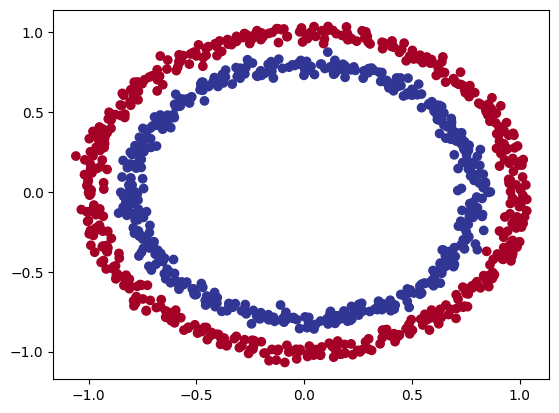

In [7]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.show()

In [8]:
X_sample = X[0]
y_sample = y[0]
X_sample,y_sample, X_sample.shape, y_sample.shape

(array([0.75424625, 0.23148074]), np.int64(1), (2,), ())

In [9]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42)

In [11]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
X_train.shape

torch.Size([800, 2])

In [14]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        #self.layer_1 = nn.Linear(in_features=2, out_features=5)
        #self.layer_2 = nn.Linear(in_features=5, out_features=1)

        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        #return self.layer_2(self.layer_1(x))
        return self.two_linear_layers(x)
    

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [15]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [16]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.2197,  0.3434],
                      [ 0.0502, -0.4048],
                      [ 0.6724,  0.4898],
                      [-0.1032, -0.2457],
                      [-0.6798, -0.2813]], device='cuda:0')),
             ('0.bias',
              tensor([-0.2496,  0.6589, -0.2025,  0.4557,  0.6228], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.3218, -0.4040,  0.0685, -0.0084,  0.2811]], device='cuda:0')),
             ('1.bias', tensor([0.2899], device='cuda:0'))])

In [18]:
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
len(untrained_preds), untrained_preds.shape
untrained_preds[:10], y_test[:10]

(tensor([[ 0.2933],
         [ 0.3206],
         [ 0.0940],
         [ 0.3503],
         [-0.1085],
         [-0.0902],
         [ 0.1473],
         [ 0.0505],
         [ 0.1029],
         [ 0.3202]], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

In [19]:
#loss_fn = nn.BCELoss()
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [20]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct/len(y_pred)) * 100
    return accuracy

In [21]:
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
with torch.inference_mode():
    y_logits = model_0(X_test[:5].to(device))

y_logits    

tensor([[ 0.2933],
        [ 0.3206],
        [ 0.0940],
        [ 0.3503],
        [-0.1085]], device='cuda:0')

In [23]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5728],
        [0.5795],
        [0.5235],
        [0.5867],
        [0.4729]], device='cuda:0')

In [24]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 0.], device='cuda:0')

In [25]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss = loss_fn(torch.sigmoid(y_logits, 
    #                              y_train)) # if loss is BCELoss
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():

        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, 
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")    


Epoch: 0 | Loss: 0.69651, Acc: 52.62% | Test loss: 0.70154, Test acc: 49.00%
Epoch: 10 | Loss: 0.69560, Acc: 51.62% | Test loss: 0.70083, Test acc: 49.50%
Epoch: 20 | Loss: 0.69520, Acc: 51.00% | Test loss: 0.70039, Test acc: 48.00%
Epoch: 30 | Loss: 0.69494, Acc: 50.75% | Test loss: 0.70002, Test acc: 47.50%
Epoch: 40 | Loss: 0.69475, Acc: 50.75% | Test loss: 0.69967, Test acc: 47.50%
Epoch: 50 | Loss: 0.69458, Acc: 51.00% | Test loss: 0.69935, Test acc: 47.00%
Epoch: 60 | Loss: 0.69444, Acc: 50.75% | Test loss: 0.69905, Test acc: 47.50%
Epoch: 70 | Loss: 0.69431, Acc: 50.62% | Test loss: 0.69878, Test acc: 47.50%
Epoch: 80 | Loss: 0.69420, Acc: 50.75% | Test loss: 0.69853, Test acc: 47.50%
Epoch: 90 | Loss: 0.69410, Acc: 50.62% | Test loss: 0.69830, Test acc: 47.50%
Epoch: 100 | Loss: 0.69401, Acc: 50.50% | Test loss: 0.69809, Test acc: 47.50%
Epoch: 110 | Loss: 0.69392, Acc: 50.25% | Test loss: 0.69790, Test acc: 47.50%
Epoch: 120 | Loss: 0.69385, Acc: 50.25% | Test loss: 0.69773, T

In [26]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print("helper_functions.py alredy exists, skipping download")
else:
    print("Downloading helper_functions.py")    
    request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py alredy exists, skipping download


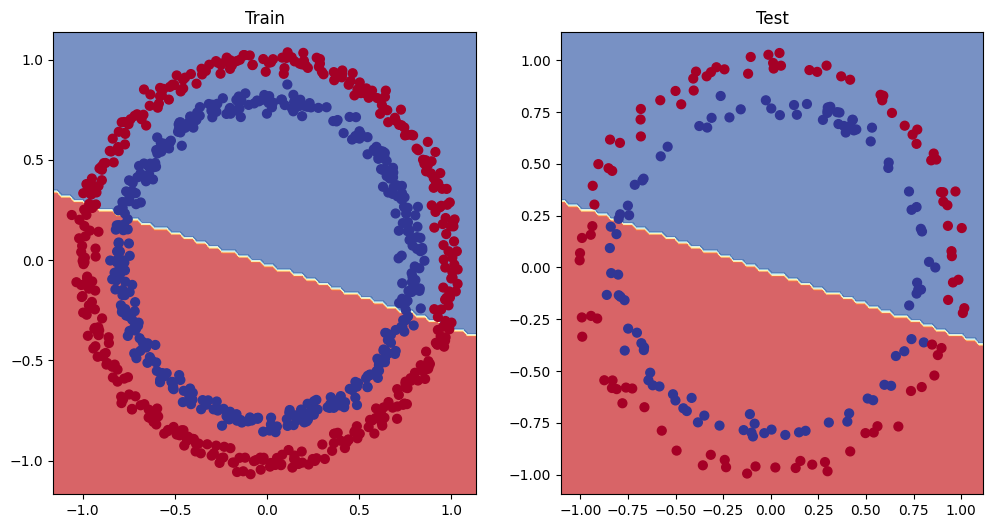

In [27]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

In [28]:
# Improving model
# 1. more layers
# 2. more hiiden units
# 3. fit for longer
# 4. change the activation model
# 5. change the learning learn


class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_1 = CircleModelV1().to(device)  
model_1  

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [29]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

for epoch in range(epochs):

    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # loss = loss_fn(torch.sigmoid(y_logits, 
    #                              y_train)) # if loss is BCELoss
    loss = loss_fn(y_logits,
                   y_train)
    
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model_1.eval()
    with torch.inference_mode():

        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, 
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")    


Epoch: 0 | Loss: 0.69396, Acc: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Acc: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Acc: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Acc: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Acc: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Acc: 51.00% | Test loss: 0.69468, Test acc: 46.00%


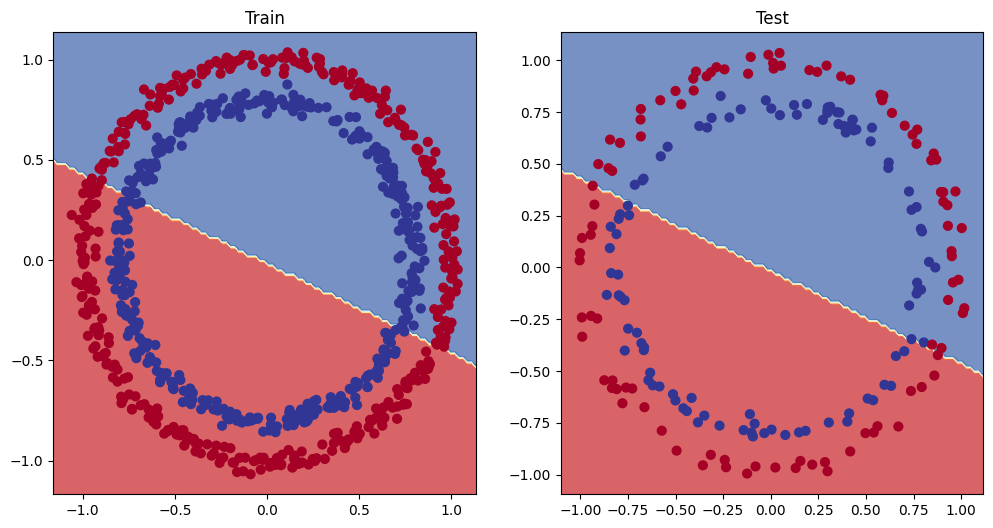

In [31]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [32]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.01

X_regression = torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

In [33]:
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regrerssion, y_test_regression = X_regression[train_split:], y_regression[train_split:]

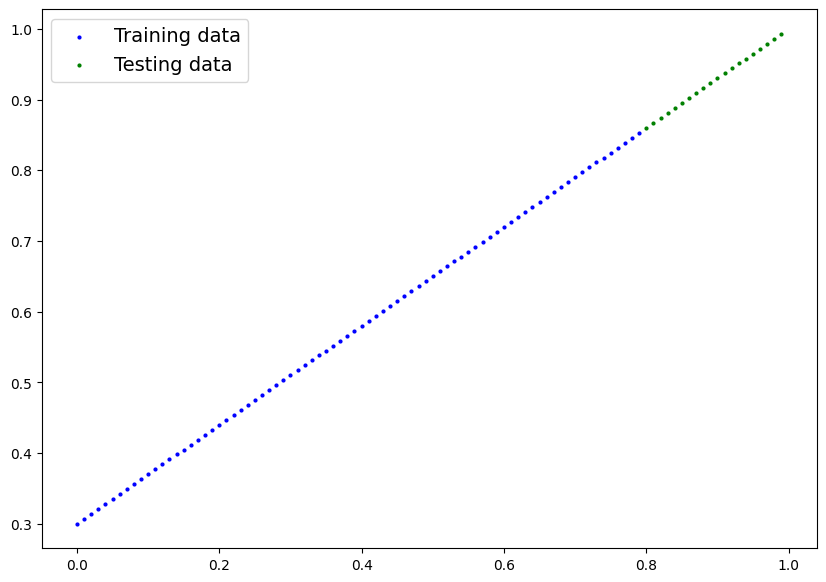

In [34]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regrerssion,
                 test_labels=y_test_regression)

In [35]:
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

loss_fn_regression = nn.L1Loss()
optimizer_regression = torch.optim.SGD(params=model_2.parameters(), 
                                       lr=0.01)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [36]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regrerssion, y_test_regression = X_test_regrerssion.to(device), y_test_regression.to(device)

epochs = 1000

for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn_regression(y_pred, y_train_regression)
    optimizer_regression.zero_grad()
    loss.backward()
    optimizer_regression.step()

    model_2.eval()
    with torch.inference_mode():

        test_pred = model_2(X_test_regrerssion)
        test_loss = loss_fn_regression(test_pred, y_test_regression)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}")
    

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


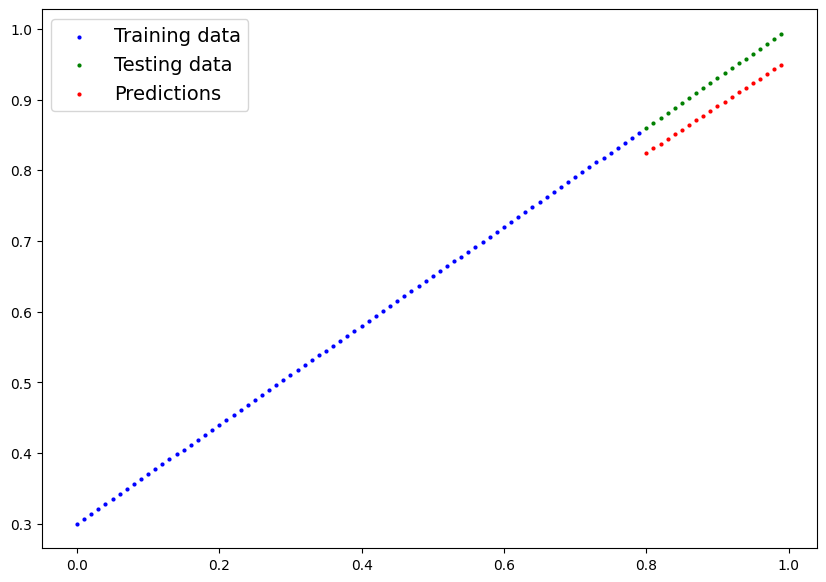

In [37]:
model_2.eval()
with torch.inference_mode():
    y_pred_regression = model_2(X_test_regrerssion)

plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regrerssion.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_pred_regression.cpu())

In [38]:
# Non-linearity

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)

model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [39]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)



In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1500

for epoch in range(epochs):
    model_3.train()

    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    model_3.eval()
    with torch.inference_mode():
        
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, 
                            y_test)
        
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.69295, Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 100 | Loss: 0.69115, Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 200 | Loss: 0.68977, Acc: 53.37% | Test loss: 0.68940, Test acc: 55.00%
Epoch: 300 | Loss: 0.68795, Acc: 53.00% | Test loss: 0.68723, Test acc: 56.00%
Epoch: 400 | Loss: 0.68517, Acc: 52.75% | Test loss: 0.68411, Test acc: 56.50%
Epoch: 500 | Loss: 0.68102, Acc: 52.75% | Test loss: 0.67941, Test acc: 56.50%
Epoch: 600 | Loss: 0.67515, Acc: 54.50% | Test loss: 0.67285, Test acc: 56.00%
Epoch: 700 | Loss: 0.66659, Acc: 58.38% | Test loss: 0.66322, Test acc: 59.00%
Epoch: 800 | Loss: 0.65160, Acc: 64.00% | Test loss: 0.64757, Test acc: 67.50%
Epoch: 900 | Loss: 0.62362, Acc: 74.00% | Test loss: 0.62145, Test acc: 79.00%
Epoch: 1000 | Loss: 0.56818, Acc: 87.75% | Test loss: 0.57378, Test acc: 86.50%
Epoch: 1100 | Loss: 0.48153, Acc: 93.50% | Test loss: 0.49935, Test acc: 90.50%
Epoch: 1200 | Loss: 0.37056, Acc: 97.75% | Test loss

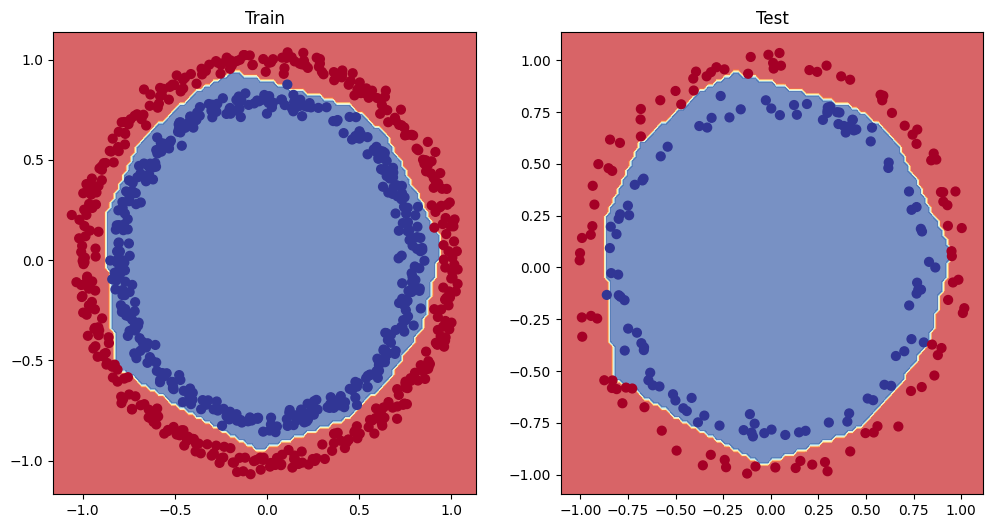

In [41]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)

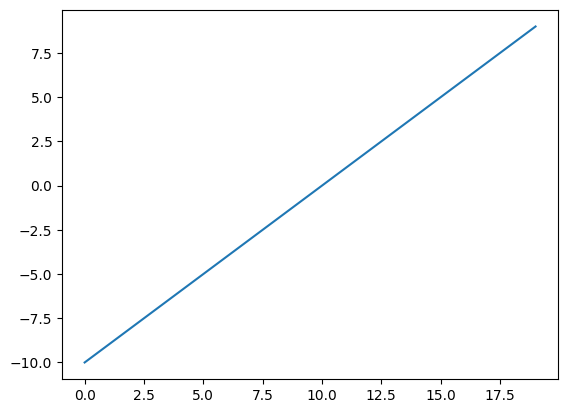

In [42]:
A = torch.arange(-10,10,1,dtype=torch.float)
plt.plot(A)

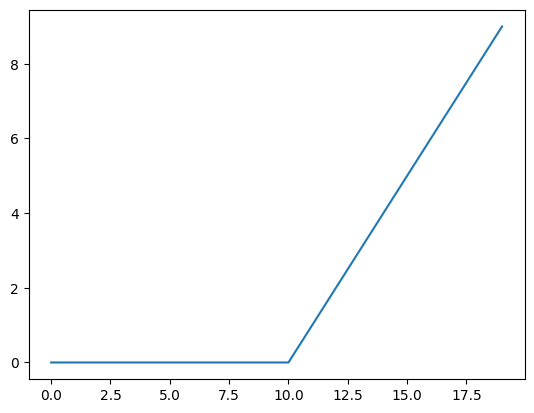

In [43]:
plt.plot(torch.relu(A))


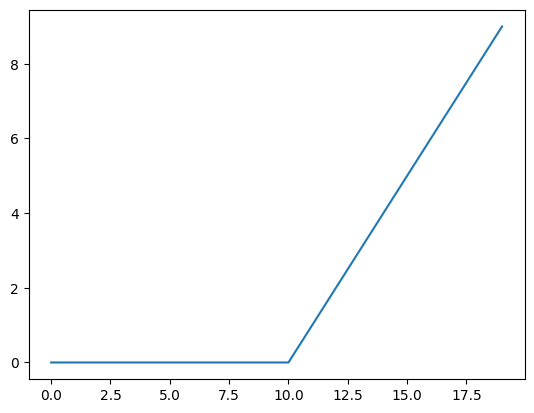

In [44]:
def ReLU(x):
    return torch.maximum(torch.tensor(0), x)

ReLU(A)

plt.plot(ReLU(A))

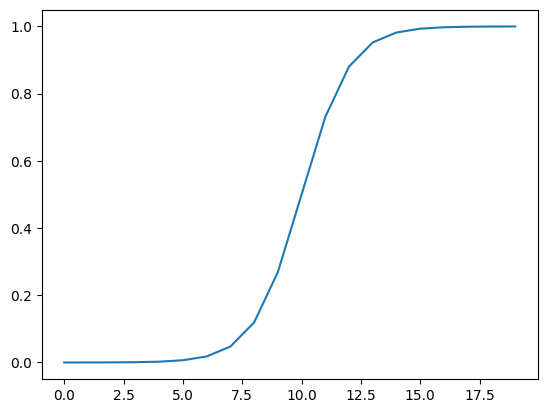

In [45]:
def Sigmoid(x):
    return 1 / (1 + torch.exp(-x))

plt.plot(Sigmoid(A))

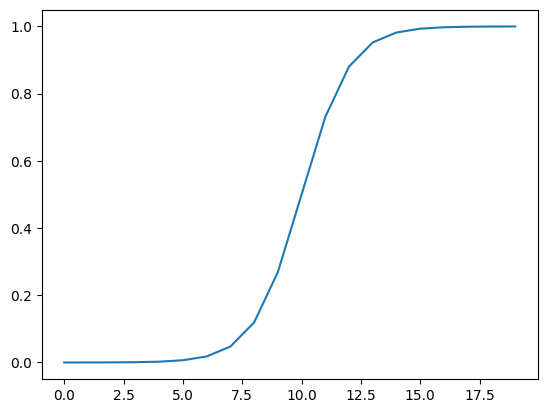

In [46]:
plt.plot(torch.sigmoid(A))

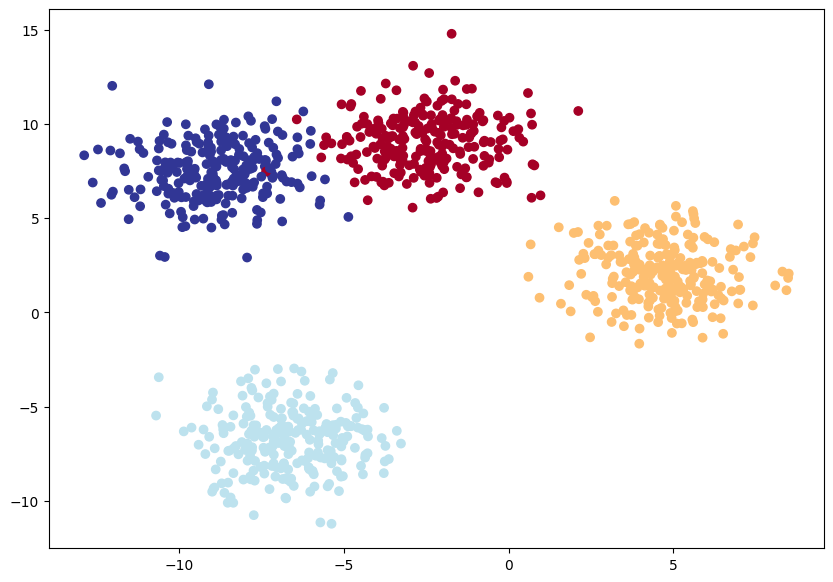

In [47]:
import torch 
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, 
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [48]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [49]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.linear_layer_stack(x)   

model_4 = BlobModel(input_features=2, 
                    output_features=4,
                    hidden_units=8).to(device)
print(next(model_4.parameters()).device)
     


cuda:0


In [50]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

In [51]:
# X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
# X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
# plt.title("Train")
# plot_decision_boundary(model_4, X_blob_train, y_blob_train)
# plt.subplot(1,2,2)
# plt.title("Test")
# plot_decision_boundary(model_4, X_blob_test, y_blob_test)    

In [52]:

model_4.eval()
with torch.inference_mode():
    y_blob_logits = model_4(X_blob_train.to(device))


y_blob_preds = torch.softmax(y_blob_logits, dim=1)
print(y_blob_logits[:5])
print(y_blob_preds[:5])

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0')
tensor([[0.1838, 0.3422, 0.1500, 0.3239],
        [0.2199, 0.0377, 0.1839, 0.5586],
        [0.3406, 0.0482, 0.5326, 0.0785],
        [0.3405, 0.0657, 0.4446, 0.1492],
        [0.2527, 0.0424, 0.2283, 0.4766]], device='cuda:0')


In [53]:
torch.sum(y_blob_preds[0])

tensor(1.0000, device='cuda:0')

In [54]:
y_preds = torch.argmax(y_blob_preds, dim=1)
y_preds[:5]

tensor([1, 3, 2, 2, 3], device='cuda:0')

In [55]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    model_4.train()

    y_logit = model_4(X_blob_train)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    loss = loss_fn(y_logit, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_4.eval()
    with torch.inference_mode():
        
        test_logits = model_4(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, 
                            y_blob_test)
        
        test_acc = accuracy_fn(y_true=y_blob_test,
                               y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%") 





Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test loss: 0.57861, Test acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test loss: 0.13037, Test acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test loss: 0.07216, Test acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test loss: 0.05133, Test acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test loss: 0.04098, Test acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test loss: 0.03486, Test acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test loss: 0.03083, Test acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test loss: 0.02799, Test acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test loss: 0.02587, Test acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test loss: 0.02423, Test acc: 99.50%


In [56]:
model_4.eval()
with torch.inference_mode():
    y_blob_logits = model_4(X_blob_test)

y_blob_preds = torch.softmax(y_blob_logits, dim=1).argmax(dim=1)   

y_blob_preds[:5], y_blob_test[:5]


(tensor([1, 3, 2, 1, 0], device='cuda:0'),
 tensor([1, 3, 2, 1, 0], device='cuda:0'))

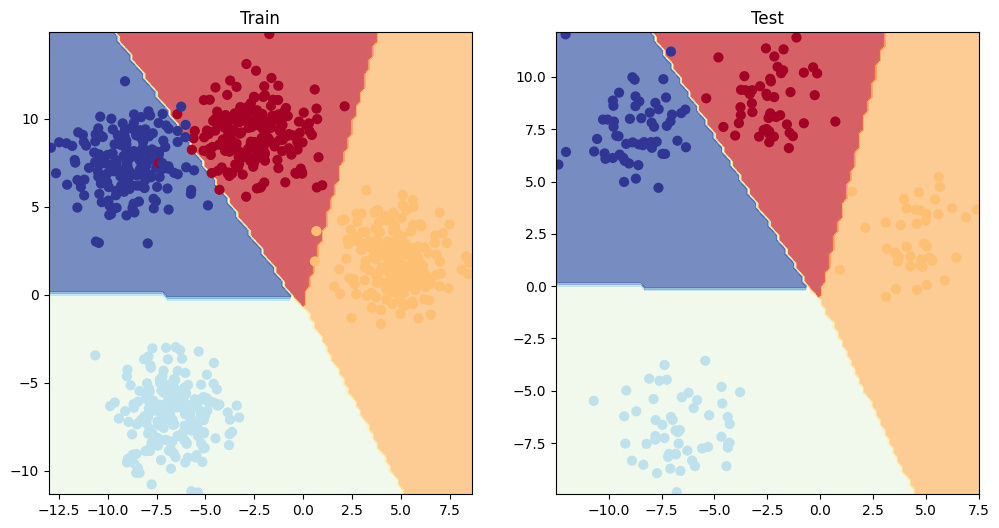

In [57]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test) 

In [58]:
from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

torchmetric_accuracy(y_blob_preds, y_blob_test)

tensor(0.9950, device='cuda:0')

In [132]:
# Exercises

import torch
from torch import nn
from helper_functions import plot_decision_boundary, plot_predictions
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torchmetrics import Accuracy


In [133]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [134]:
n_samples = 1000
X, y = make_moons(n_samples=n_samples, noise=0.15, random_state=42)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.0816,  0.4822],
         [ 1.0873, -0.3812],
         [ 0.8317, -0.1331],
         [ 0.2003, -0.5003],
         [-0.8250,  0.5395]]),
 tensor([1., 1., 1., 1., 0.]))

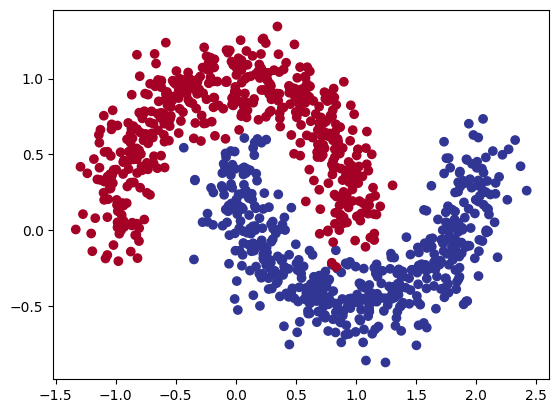

In [135]:
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

In [146]:
class MoonsModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            # nn.Linear(in_features=hidden_units, out_features=hidden_units),            
            # nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )

    def forward(self, x):
        return self.layer_stack(x)  


model_moons = MoonsModel(input_features=2, output_features=1, hidden_units=12).to(device)
model_moons      

MoonsModel(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
    (2): Linear(in_features=12, out_features=12, bias=True)
    (3): ReLU()
    (4): Linear(in_features=12, out_features=1, bias=True)
  )
)

In [147]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_moons.parameters(), lr=0.1)

torchmetric_accuracy = Accuracy(task='binary').to(device)

In [148]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    model_moons.train()

    y_logits = model_moons(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = torchmetric_accuracy(y_pred, y_train) * 100

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_moons.eval()
    with torch.inference_mode():
        y_test_logits = model_moons(X_test).squeeze()
        y_test_pred = torch.round(torch.sigmoid(y_test_logits))
        loss_test = loss_fn(y_test_logits, y_test)
        acc_test = torchmetric_accuracy(y_test_pred, y_test ) * 100

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Acc: {acc}% | Test Loss: {loss_test} | Test acc: {acc_test}%")



Epoch: 0 | Loss: 0.6818413138389587 | Acc: 50.0% | Test Loss: 0.6839902997016907 | Test acc: 50.0%
Epoch: 10 | Loss: 0.664297878742218 | Acc: 59.750003814697266% | Test Loss: 0.6681727170944214 | Test acc: 59.500003814697266%
Epoch: 20 | Loss: 0.6435307860374451 | Acc: 69.75% | Test Loss: 0.6496540904045105 | Test acc: 67.5%
Epoch: 30 | Loss: 0.6196197271347046 | Acc: 72.875% | Test Loss: 0.6288732290267944 | Test acc: 70.0%
Epoch: 40 | Loss: 0.5938304662704468 | Acc: 74.375% | Test Loss: 0.606155514717102 | Test acc: 72.0%
Epoch: 50 | Loss: 0.567750871181488 | Acc: 75.25% | Test Loss: 0.582790732383728 | Test acc: 70.0%
Epoch: 60 | Loss: 0.5424096584320068 | Acc: 75.625% | Test Loss: 0.5597991943359375 | Test acc: 72.0%
Epoch: 70 | Loss: 0.5186871290206909 | Acc: 77.625% | Test Loss: 0.5378938913345337 | Test acc: 73.5%
Epoch: 80 | Loss: 0.497037798166275 | Acc: 79.125% | Test Loss: 0.5172920227050781 | Test acc: 72.5%
Epoch: 90 | Loss: 0.477606862783432 | Acc: 79.375% | Test Loss: 0.

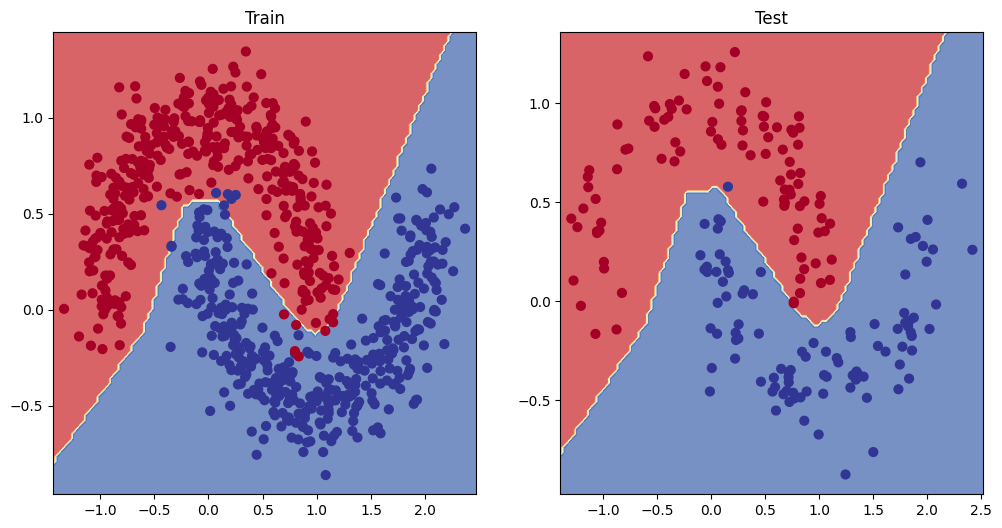

In [149]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model=model_moons, X=X_train, y=y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model=model_moons, X=X_test, y=y_test)

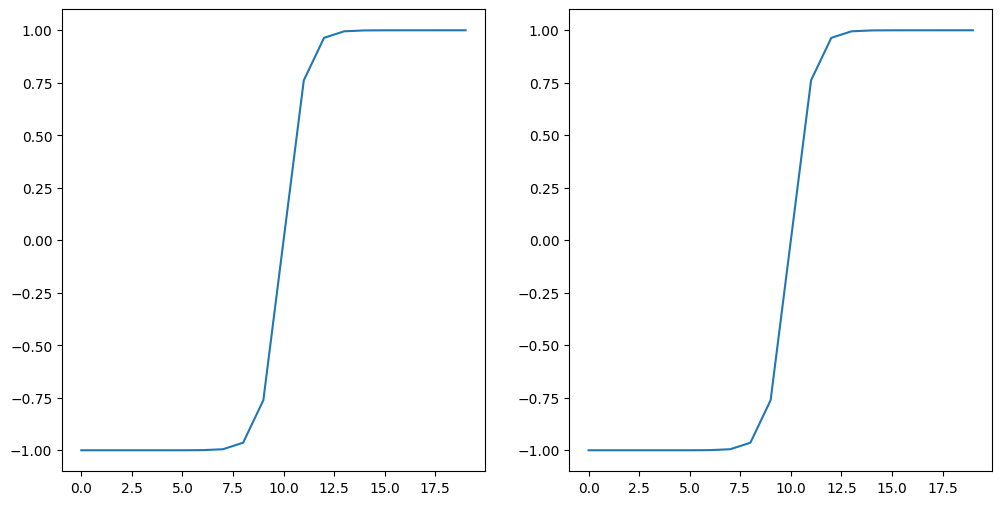

In [154]:
def Tanh(x):
    return (torch.exp(x) - torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))


x_range = torch.arange(-10,10,1)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(Tanh(x_range))
plt.subplot(1,2,2)
plt.plot(torch.tanh(x_range))
plt.show()

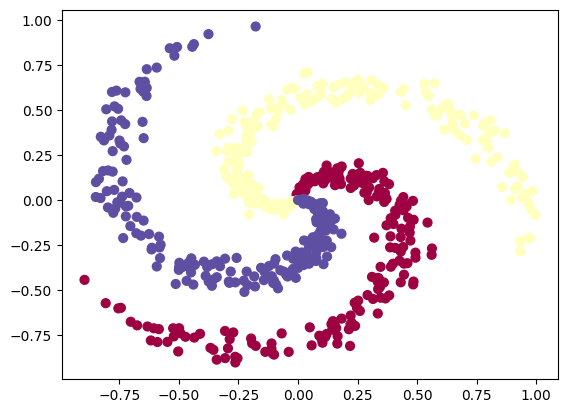

In [242]:
import numpy as np
N = 200 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [243]:
X = torch.from_numpy(X).type(torch.float).to(device)
y = torch.from_numpy(y).type(torch.LongTensor).to(device)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([480, 2]),
 torch.Size([120, 2]),
 torch.Size([480]),
 torch.Size([120]))

In [244]:
class SpiralModel(nn.Module):
    def __init__(self,input_features, output_features):
        super().__init__()
        self.layer_stack_1 = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=12),
            nn.ReLU(),
            # nn.Linear(in_features=12, out_features=12),
            # nn.ReLU()
        )
        self.layer_stack_2 = nn.Sequential(
            # nn.Linear(in_features=12, out_features=6),
            # nn.Tanh(),
            nn.Linear(in_features=12, out_features=6),
            nn.Tanh(),
            nn.Linear(in_features=6, out_features=output_features)
        ) 

    def forward(self, x):
        return self.layer_stack_2(self.layer_stack_1(x))    

model_spiral = SpiralModel(input_features=2, output_features=3).to(device)
model_spiral

SpiralModel(
  (layer_stack_1): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU()
  )
  (layer_stack_2): Sequential(
    (0): Linear(in_features=12, out_features=6, bias=True)
    (1): Tanh()
    (2): Linear(in_features=6, out_features=3, bias=True)
  )
)

In [245]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_spiral.parameters(), lr=0.03)


In [246]:
torchmetric_accuracy = Accuracy(task='multiclass', num_classes=3).to(device)

In [247]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 200

for epoch in range(epochs):
    model_spiral.train()
    
    y_logits = model_spiral(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    loss = loss_fn(y_logits, y_train)
    acc = torchmetric_accuracy(y_preds, y_train) * 100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        model_spiral.eval()
        with torch.inference_mode():
            y_test_logits = model_spiral(X_test)
            y_test_preds = torch.softmax(y_test_logits, dim=1).argmax(dim=1)

            test_loss = loss_fn(y_test_logits, y_test)
            acc_test = torchmetric_accuracy(y_test_preds, y_test) * 100
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.2f}% | Test loss {test_loss:.5f} | Test acc: {acc_test:.2f}%")    
        


Epoch: 0 | Loss: 1.14384 | Acc: 31.25% | Test loss 1.07254 | Test acc: 41.67%
Epoch: 10 | Loss: 0.93651 | Acc: 58.12% | Test loss 0.89907 | Test acc: 59.17%
Epoch: 20 | Loss: 0.69986 | Acc: 60.42% | Test loss 0.67215 | Test acc: 58.33%
Epoch: 30 | Loss: 0.58781 | Acc: 66.67% | Test loss 0.54898 | Test acc: 70.00%
Epoch: 40 | Loss: 0.47721 | Acc: 73.96% | Test loss 0.44816 | Test acc: 78.33%
Epoch: 50 | Loss: 0.37334 | Acc: 80.42% | Test loss 0.33409 | Test acc: 82.50%
Epoch: 60 | Loss: 0.26986 | Acc: 87.29% | Test loss 0.23751 | Test acc: 89.17%
Epoch: 70 | Loss: 0.19859 | Acc: 93.54% | Test loss 0.15810 | Test acc: 93.33%
Epoch: 80 | Loss: 0.15224 | Acc: 95.62% | Test loss 0.11735 | Test acc: 97.50%
Epoch: 90 | Loss: 0.12351 | Acc: 96.25% | Test loss 0.08901 | Test acc: 96.67%
Epoch: 100 | Loss: 0.10509 | Acc: 97.50% | Test loss 0.07536 | Test acc: 98.33%
Epoch: 110 | Loss: 0.09139 | Acc: 97.50% | Test loss 0.06491 | Test acc: 98.33%
Epoch: 120 | Loss: 0.08045 | Acc: 97.50% | Test los

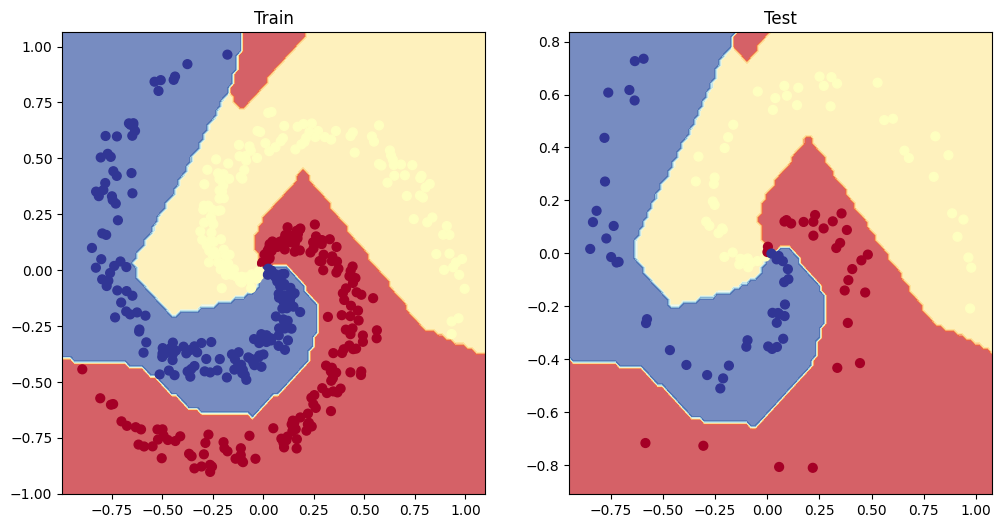

In [248]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_spiral, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_spiral, X_test, y_test)